In [2]:
from collections import defaultdict
import re
import math
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import pyproj
import matplotlib.cm as cm
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.legend import Legend
import sys
import os
import matplotlib
import matplotlib.colors as colors
import camelot
pd.set_option('display.max_colwidth', -1)

In [3]:
df = pd.read_csv("seeds_ii_replica (1).csv")
df.head()

C:\Users\KL-LocalAdmin\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (148) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,geoid,gisjoin,state_fips,state_name,state_abbr,county_name,county_fips,tract_fips,area_km2,centroid_x,...,climate_zone_description,moisture_regime,locale,total_units,active_subsidies,avg_months_tenancy,fmr_2br,occ_rate,pct_eli_hh,lihtc_qualified
0,6001400100,G0600010400100,6,California,CA,Alameda County,1,400100,6.894336,-122.231947,...,Warm,C,City - Large,NaN,NaN,NaN,NaN,NaN,NaN,False
1,6001408100,G0600010408100,6,California,CA,Alameda County,1,408100,8.935563,-122.157212,...,Warm,C,City - Large,NaN,NaN,NaN,NaN,NaN,NaN,False
2,6001409000,G0600010409000,6,California,CA,Alameda County,1,409000,16.927907,-122.212192,...,Warm,C,City - Large,NaN,NaN,NaN,NaN,NaN,NaN,True
3,6001409900,G0600010409900,6,California,CA,Alameda County,1,409900,4.332550,-122.135826,...,Warm,C,City - Large,NaN,NaN,NaN,NaN,NaN,NaN,False
4,6001422000,G0600010422000,6,California,CA,Alameda County,1,422000,4.727481,-122.302847,...,Warm,C,City - Midsize,NaN,NaN,NaN,NaN,NaN,NaN,True


In [4]:
if "REPLICA Schema.csv" in os.listdir():
    schema = pd.read_csv("REPLICA Schema.csv")
    
else:
    
    ## Creation of schema file (data dictionary)
    schema_list = camelot.read_pdf("SEEDSII REPLICA Documentation (1).pdf", pages='7-20')

    schema = schema_list[0].df.copy()
    for i in range(1, 14):
        schema = schema.append(schema_list[i].df)

    schema = schema.reset_index(drop=True)
    schema[1] = schema[1].str.replace("\n", "")
    schema[2] = schema[2].str.replace("\n", "")

    schema.loc[33, 1] = schema.loc[33, 1] + schema.loc[34, 1]
    schema.loc[33, 2] = schema.loc[33, 2] + " " + schema.loc[34, 2]
    schema.drop(34, inplace=True)

    schema.loc[41, 2] = schema.loc[41, 1].split(" ", 1)[-1] + " " + schema.loc[41, 2]
    schema.loc[41, 1] = schema.loc[41, 1].split(" ", 1)[0]

    schema.loc[65, 2] = (schema.loc[65, 1].split(" ", 1)[-1] + " " + schema.loc[66, 2]).strip()
    schema.loc[65, 1] = schema.loc[65, 1].split(" ", 1)[0]
    schema.drop(66, inplace=True)

    schema.loc[86, 2] = (schema.loc[86, 1].split(" ", 1)[-1] + " " + schema.loc[86, 2]).strip()
    schema.loc[86, 1] = schema.loc[86, 1].split(" ", 1)[0]

    schema.loc[97, 2] = (schema.loc[97, 2] + " " + schema.loc[98, 2]).strip()
    schema.drop(98, inplace=True)

    schema.loc[129, 2] = schema.loc[129, 2] + " " + schema.loc[130, 2]
    schema.drop(130, inplace=True)

    schema = schema[[1, 2]]
    schema.columns = ["Field Name", "Description"]
    schema = schema.loc[1:]
    schema.reset_index(drop=True, inplace=True)

    schema.to_csv("REPLICA Schema.csv", index=False)

In [43]:
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
schema.head(20)

,Field Name,Description
0,geoid,Tract GEOID
1,gisjoin,Tract GISJOIN
2,state_fips,State FIPS Code
3,state_name,State Name
4,state_abbr,State Abbreviation
5,county_name,County Name
6,county_fips,County FIPS Code
7,tract_fips,Tract FIPS Code
8,area_km2,Tract Area (sq.km)
9,centroid_x,Tract Centroid Longitude


## First Chart - Solar Energy Suitable Areas vs Climate

In [6]:
area_columns = [a for a in df.columns if "_m2" in a]
df["suitable_area_m2_total"] = df[area_columns].sum(axis=1)

In [7]:
## only 4 census tracts' climate zone have null values
df[["state_abbr", "suitable_area_m2_total", "area_km2", "climate_zone"]].isna().sum()

state_abbr                0
suitable_area_m2_total    0
area_km2                  0
climate_zone              4
dtype: int64

In [8]:
# function to calculated weighted average even with nan values
def weighted_mean(weight_index):
    return lambda x: np.average(x[~np.isnan(x)], weights=df.loc[x[~np.isnan(x)].index, weight_index])

## Grouping census tract data, weighted mean by total area
df_1 = df[["state_abbr", "suitable_area_m2_total", "area_km2", "climate_zone"]].groupby("state_abbr").agg({
    "suitable_area_m2_total":np.sum,
    "area_km2":np.sum,
    "climate_zone": weighted_mean("area_km2")
}).reset_index()

## 10^6 m2 equals 1 km^2
## Calculating suitable solar area fraction
df_1["solar_area_fraction"] = df_1["suitable_area_m2_total"] / df_1["area_km2"] / 10 ** 6
df_1 = df_1.sort_values("solar_area_fraction", ascending=False)

## Climate zone referenced by number 1-8 (1 is extremely hot, 8 is extremely cold)
## We are flipping those numbers (1 is extremely cold and 8 is extremely hot)
df_1["climate_adjusted"] = 9 - df_1["climate_zone"]

## DC is throwing up unusually high values, so removing it, also it is not a proper state but the capital
df_1 = df_1[df_1["solar_area_fraction"] < 0.01]
df_1 = df_1.reset_index(drop=True)

In [39]:
df_1.head()

,state_abbr,suitable_area_m2_total,area_km2,climate_zone,solar_area_fraction,climate_adjusted
0,NJ,1.298038e+08,19558.588365,4.37567,0.006637,4.62433
1,MA,1.269278e+08,20990.933173,5.00000,0.006047,4.00000
2,RI,1.562739e+07,2817.488726,5.00000,0.005547,4.00000
3,CT,5.835678e+07,12863.951788,5.00000,0.004536,4.00000
4,MD,8.748449e+07,25577.505957,4.06640,0.003420,4.93360


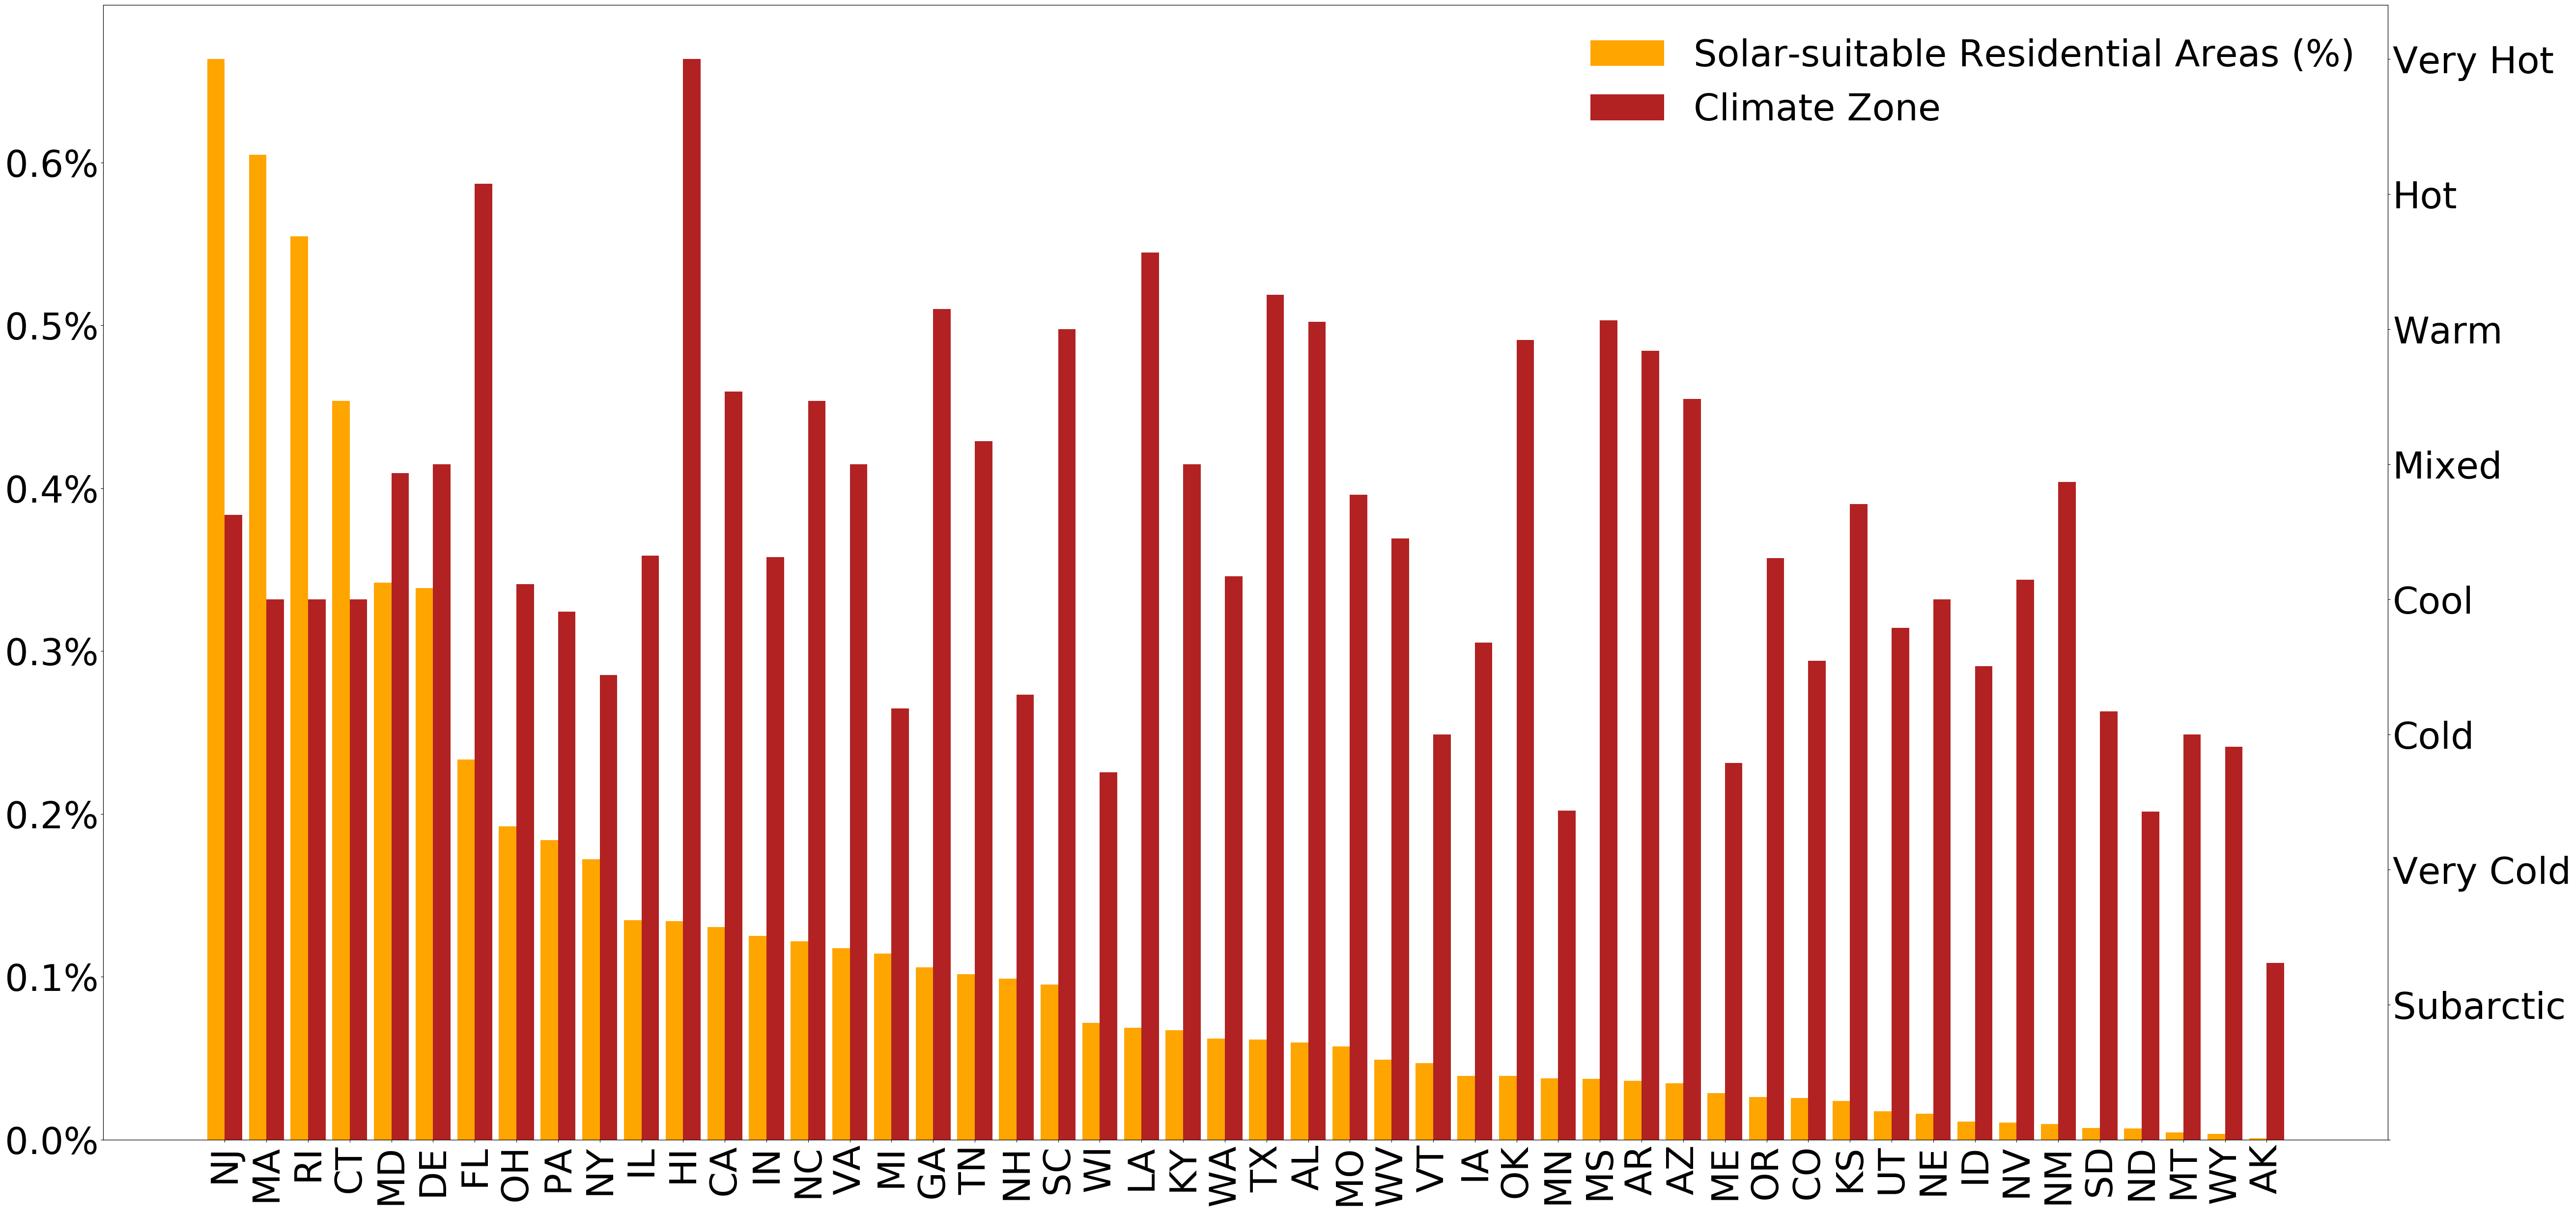

In [10]:
matplotlib.rcdefaults()

## Forcing all font sizes to 54
font = {'size'   : 54}
matplotlib.rc('font', **font)

x = np.arange(50)
w = 0.42

## Large figure size to reduce pixelation
f = plt.figure(figsize=(60, 30))
ax1 = f.add_subplot(111)

## replacing xticks with state abbreviations
plt.xticks(x, df_1['state_abbr'], rotation='vertical')

## first bar plot with solar suitable area as a fraction of total area
solar_bar = ax1.bar(x - w / 2, df_1['solar_area_fraction'], width=w, color='orange', align='center')
vals = ax1.get_yticks()
## formatting the fraction in percentage terms
ax1.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

## second bar plot with climate zones
ax2 = ax1.twinx() ## Need to twin to plot on the same block
climate_bar = ax2.bar(x + w / 2, df_1['climate_adjusted'], width=w, color='firebrick', align='center')

## climate dictionary has the climate zone description attached to it
climate_dict = df[["climate_zone",
                   "climate_zone_description"]].drop_duplicates().set_index("climate_zone").to_dict()['climate_zone_description']

# Need to draw the canvas first to change the yticklabels to text
f.canvas.draw()
labels = [item.get_text() for item in ax2.get_yticklabels()]
## Labels are going from 0-9 We need 1-8, so 0,9 can be blank
labels = [""] + [climate_dict[9 - int(item)] for item in labels[1:-1]] + [""]
ax2.set_yticklabels(labels)

## Suitable Legend at the top to avert data hiding, removing legend frame for neatness
plt.legend([solar_bar, climate_bar],["Solar-suitable Residential Areas (%)", 'Climate Zone'], loc="upper right", framealpha=0)
plt.show()

matplotlib.rcdefaults()

## Second Chart - Solar-based incentives vs Energy-economic factors
solar-based incentives on household income/electricity bills/cost per unit energy/highly solar suitable

In [11]:
## Creating dictionary to be able to access scheme column description from the column name 
schema_dict = schema.set_index("Field Name").to_dict()["Description"]

## User-designed description
schema_dict["solar_area_fraction"] = "Solar-suitable Residential Areas (%)"

## Description not available in schema for some reason
schema_dict["hh_med_income"] = "Median Household Income ($)"

In [12]:
## Calculating solar area fraction at census level
df["solar_area_fraction"] = df["suitable_area_m2_total"] / df["area_km2"] / 10 ** 6

In [16]:
def avg_state_incentive_list(df, col):
    state_incentive_dict = df[~df[col].isna()][[col,"state_abbr"]].drop_duplicates().sort_values(col).set_index("state_abbr").to_dict()[col]
    for k, v in state_incentive_dict.items():
        state_incentive_dict[k] = round(v, 3) 
        
    return state_incentive_dict

state_incentive_dict = dict()

for incentive in ["avg_pbi_usd_p_kwh", "avg_cbi_usd_p_w", "avg_ibi_pct"]:
    state_incentive_dict[incentive] = avg_state_incentive_list(df, incentive)
    
print(state_incentive_dict)

{'avg_pbi_usd_p_kwh': {'OH': 0.005, 'IL': 0.007, 'PA': 0.007, 'MD': 0.009, 'DE': 0.035, 'NC': 0.075, 'CA': 0.089, 'VT': 0.13, 'VA': 0.15, 'HI': 0.201, 'NJ': 0.22, 'RI': 0.221, 'MA': 0.27, 'UT': 0.35, 'DC': 0.48}, 'avg_cbi_usd_p_w': {'MD': 0.45, 'CT': 0.47, 'CA': 0.5, 'NH': 0.5, 'NY': 0.7, 'OR': 1.0}, 'avg_ibi_pct': {'NM': 0.1, 'WI': 0.12, 'MA': 0.15, 'IA': 0.18, 'AZ': 0.25, 'UT': 0.25, 'NY': 0.25, 'SC': 0.25, 'HI': 0.35, 'MT': 1.0}}


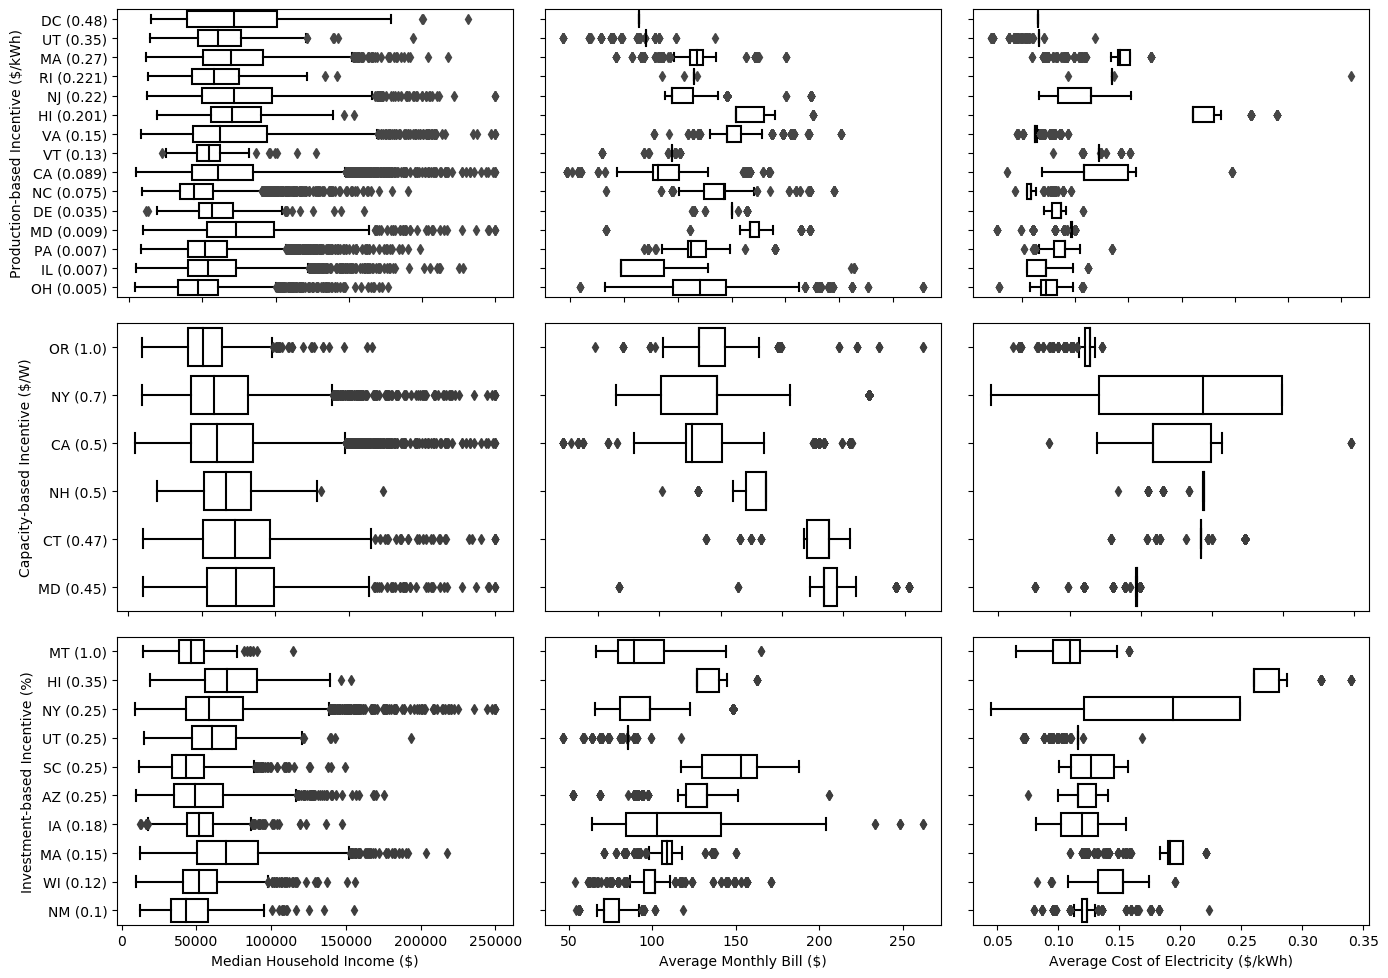

In [17]:
## Setting up the mxn boxplots
x_values = ["avg_pbi_usd_p_kwh", "avg_cbi_usd_p_w", "avg_ibi_pct"]
y_values = ["hh_med_income", "avg_monthly_bill_dlrs", "dlrs_kwh"]#, "solar_area_fraction"]

## m x n subplots
fig, axs = plt.subplots(len(x_values), len(y_values), figsize=(14, 10))#, sharex='col', sharey='row')
fig.canvas.draw()


for x_ind, x_val in enumerate(x_values):
    for y_ind, y_val in enumerate(y_values):
        
## breaking data boxplots by states
## Higher incentive states at the top


        ax = sns.boxplot(x=y_val,
                    y="state_abbr",
                    data=df[~df[x_val].isna()].sort_values(x_val, ascending=False),
#                     palette="bright",
#                     color="white",
                    orient="h",
                    ax=axs[x_ind, y_ind])

## Setting labels
        axs[x_ind, y_ind].set_xlabel(schema_dict[y_val])
        axs[x_ind, y_ind].set_ylabel((" ").join(schema_dict[x_val].split(" ")[4:]))

## Changing y tick labels to have the incentive values attached to them
        text = [t.get_text() for t in ax.get_yticklabels()]
        axs[x_ind, y_ind].set_yticklabels([t + " (" + str(state_incentive_dict[x_val][t]) + ")" for t in text])

## Removing default palette from seaborn boxplots
        plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
        plt.setp(ax.lines, color='k')

## Only keeping the outer labels and not labeling every x and y axis
for ax in axs.flat:
    ax.label_outer()
    
plt.tight_layout()

## Third Chart - Solar-fraction vs Air Quality
solar energy as fraction of total electricity vs Air Quality (median) (state weighted by area km2 area 

In [25]:
df_solar_energy = pd.read_csv("SeriesExport-11-26-2019-22-02-10.csv")
df_solar_energy = df_solar_energy.apply(lambda x: pd.to_numeric(x, errors="coerce"))
df_solar_energy = df_solar_energy.loc[6:, :].reset_index(drop=True)
df_solar_energy.head()

## Shows the utility-scale (SUN) and small-scale (DPV) solar installations of every state for every month referenced by
## series key 

,Series Key,ELEC.GEN.SUN-AL-99.M,Series Key.1,ELEC.GEN.DPV-AL-99.M,Series Key.2,ELEC.GEN.DPV-AK-99.M,Series Key.3,ELEC.GEN.SUN-AZ-99.M,Series Key.4,ELEC.GEN.DPV-AZ-99.M,Series Key.5,ELEC.GEN.SUN-AR-99.M,Series Key.6,ELEC.GEN.DPV-AR-99.M,Series Key.7,ELEC.GEN.SUN-CA-99.M,Series Key.8,ELEC.GEN.DPV-CA-99.M,Series Key.9,ELEC.GEN.SUN-CO-99.M,Series Key.10,ELEC.GEN.DPV-CO-99.M,Series Key.11,ELEC.GEN.SUN-CT-99.M,Series Key.12,ELEC.GEN.DPV-CT-99.M,Series Key.13,ELEC.GEN.SUN-DE-99.M,Series Key.14,ELEC.GEN.DPV-DE-99.M,Series Key.15,ELEC.GEN.DPV-DC-99.M,Series Key.16,ELEC.GEN.SUN-FL-99.M,Series Key.17,ELEC.GEN.DPV-FL-99.M,Series Key.18,ELEC.GEN.SUN-GA-99.M,Series Key.19,ELEC.GEN.DPV-GA-99.M,Series Key.20,ELEC.GEN.SUN-HI-99.M,Series Key.21,ELEC.GEN.DPV-HI-99.M,Series Key.22,ELEC.GEN.SUN-ID-99.M,Series Key.23,ELEC.GEN.DPV-ID-99.M,Series Key.24,ELEC.GEN.SUN-IL-99.M,Series Key.25,ELEC.GEN.DPV-IL-99.M,Series Key.26,ELEC.GEN.SUN-IN-99.M,Series Key.27,ELEC.GEN.DPV-IN-99.M,Series Key.28,ELEC.GEN.SUN-IA-99.M,Series Key.29,ELEC.GEN.DPV-IA-99.M,Series Key.30,ELEC.GEN.SUN-KS-99.M,Series Key.31,ELEC.GEN.DPV-KS-99.M,Series Key.32,ELEC.GEN.SUN-KY-99.M,Series Key.33,ELEC.GEN.DPV-KY-99.M,Series Key.34,ELEC.GEN.SUN-LA-99.M,Series Key.35,ELEC.GEN.DPV-LA-99.M,Series Key.36,ELEC.GEN.SUN-ME-99.M,Series Key.37,ELEC.GEN.DPV-ME-99.M,Series Key.38,ELEC.GEN.SUN-MD-99.M,Series Key.39,ELEC.GEN.DPV-MD-99.M,Series Key.40,ELEC.GEN.SUN-MA-99.M,Series Key.41,ELEC.GEN.DPV-MA-99.M,Series Key.42,ELEC.GEN.SUN-MI-99.M,Series Key.43,ELEC.GEN.DPV-MI-99.M,Series Key.44,ELEC.GEN.SUN-MN-99.M,Series Key.45,ELEC.GEN.DPV-MN-99.M,Series Key.46,ELEC.GEN.SUN-MS-99.M,Series Key.47,ELEC.GEN.DPV-MS-99.M,Series Key.48,ELEC.GEN.SUN-MO-99.M,Series Key.49,ELEC.GEN.DPV-MO-99.M,Series Key.50,ELEC.GEN.SUN-MT-99.M,Series Key.51,ELEC.GEN.DPV-MT-99.M,Series Key.52,ELEC.GEN.SUN-NE-99.M,Series Key.53,ELEC.GEN.DPV-NE-99.M,Series Key.54,ELEC.GEN.SUN-NV-99.M,Series Key.55,ELEC.GEN.DPV-NV-99.M,Series Key.56,ELEC.GEN.DPV-NH-99.M,Series Key.57,ELEC.GEN.SUN-NJ-99.M,Series Key.58,ELEC.GEN.DPV-NJ-99.M,Series Key.59,ELEC.GEN.SUN-NM-99.M,Series Key.60,ELEC.GEN.DPV-NM-99.M,Series Key.61,ELEC.GEN.SUN-NY-99.M,Series Key.62,ELEC.GEN.DPV-NY-99.M,Series Key.63,ELEC.GEN.SUN-NC-99.M,Series Key.64,ELEC.GEN.DPV-NC-99.M,Series Key.65,ELEC.GEN.DPV-ND-99.M,Series Key.66,ELEC.GEN.SUN-OH-99.M,Series Key.67,ELEC.GEN.DPV-OH-99.M,Series Key.68,ELEC.GEN.SUN-OK-99.M,Series Key.69,ELEC.GEN.DPV-OK-99.M,Series Key.70,ELEC.GEN.SUN-OR-99.M,Series Key.71,ELEC.GEN.DPV-OR-99.M,Series Key.72,ELEC.GEN.SUN-PA-99.M,Series Key.73,ELEC.GEN.DPV-PA-99.M,Series Key.74,ELEC.GEN.SUN-RI-99.M,Series Key.75,ELEC.GEN.DPV-RI-99.M,Series Key.76,ELEC.GEN.SUN-SC-99.M,Series Key.77,ELEC.GEN.DPV-SC-99.M,Series Key.78,ELEC.GEN.SUN-SD-99.M,Series Key.79,ELEC.GEN.DPV-SD-99.M,Series Key.80,ELEC.GEN.SUN-TN-99.M,Series Key.81,ELEC.GEN.DPV-TN-99.M,Series Key.82,ELEC.GEN.SUN-TX-99.M,Series Key.83,ELEC.GEN.DPV-TX-99.M,Series Key.84,ELEC.GEN.SUN-UT-99.M,Series Key.85,ELEC.GEN.DPV-UT-99.M,Series Key.86,ELEC.GEN.SUN-VT-99.M,Series Key.87,ELEC.GEN.DPV-VT-99.M,Series Key.88,ELEC.GEN.SUN-VA-99.M,Series Key.89,ELEC.GEN.DPV-VA-99.M,Series Key.90,ELEC.GEN.SUN-WA-99.M,Series Key.91,ELEC.GEN.DPV-WA-99.M,Series Key.92,ELEC.GEN.DPV-WV-99.M,Series Key.93,ELEC.GEN.SUN-WI-99.M,Series Key.94,ELEC.GEN.DPV-WI-99.M
0,201908.0,40.62006,201908.0,NaN,201908.0,0.56886,201908.0,563.78063,201908.0,239.41760,201908.0,23.88443,201908.0,3.71050,201908.0,3264.79053,201908.0,1578.67924,201908.0,133.00905,201908.0,62.64570,201908.0,17.02143,201908.0,65.93327,201908.0,5.48469,201908.0,12.64088,201908.0,8.62534,201908.0,331.03744,201908.0,64.11420,201908.0,212.64243,201908.0,NaN,201908.0,23.29575,201908.0,106.23269,201908.0,62.73728,201908.0,6.86352,201908.0,7.25904,201908.0,22.03577,201908.0,36.47928,201908.0,14.00764,201908.0,NaN,201908.0,17.31085,201908.0,NaN,201908.0,3.96492,201908.0,4.36203,201908.0,4.23816,201908.0,NaN,201908.0,23.10392,201908.0,NaN,201908.0,8.43487,201908.0,53.27522,201908.0,104

In [26]:
df_solar_energy[(201501 <= df_solar_energy["Series Key.8"]) & (df_solar_energy["Series Key.8"] <= 201512)]

,Series Key,ELEC.GEN.SUN-AL-99.M,Series Key.1,ELEC.GEN.DPV-AL-99.M,Series Key.2,ELEC.GEN.DPV-AK-99.M,Series Key.3,ELEC.GEN.SUN-AZ-99.M,Series Key.4,ELEC.GEN.DPV-AZ-99.M,Series Key.5,ELEC.GEN.SUN-AR-99.M,Series Key.6,ELEC.GEN.DPV-AR-99.M,Series Key.7,ELEC.GEN.SUN-CA-99.M,Series Key.8,ELEC.GEN.DPV-CA-99.M,Series Key.9,ELEC.GEN.SUN-CO-99.M,Series Key.10,ELEC.GEN.DPV-CO-99.M,Series Key.11,ELEC.GEN.SUN-CT-99.M,Series Key.12,ELEC.GEN.DPV-CT-99.M,Series Key.13,ELEC.GEN.SUN-DE-99.M,Series Key.14,ELEC.GEN.DPV-DE-99.M,Series Key.15,ELEC.GEN.DPV-DC-99.M,Series Key.16,ELEC.GEN.SUN-FL-99.M,Series Key.17,ELEC.GEN.DPV-FL-99.M,Series Key.18,ELEC.GEN.SUN-GA-99.M,Series Key.19,ELEC.GEN.DPV-GA-99.M,Series Key.20,ELEC.GEN.SUN-HI-99.M,Series Key.21,ELEC.GEN.DPV-HI-99.M,Series Key.22,ELEC.GEN.SUN-ID-99.M,Series Key.23,ELEC.GEN.DPV-ID-99.M,Series Key.24,ELEC.GEN.SUN-IL-99.M,Series Key.25,ELEC.GEN.DPV-IL-99.M,Series Key.26,ELEC.GEN.SUN-IN-99.M,Series Key.27,ELEC.GEN.DPV-IN-99.M,Series Key.28,ELEC.GEN.SUN-IA-99.M,Series Key.29,ELEC.GEN.DPV-IA-99.M,Series Key.30,ELEC.GEN.SUN-KS-99.M,Series Key.31,ELEC.GEN.DPV-KS-99.M,Series Key.32,ELEC.GEN.SUN-KY-99.M,Series Key.33,ELEC.GEN.DPV-KY-99.M,Series Key.34,ELEC.GEN.SUN-LA-99.M,Series Key.35,ELEC.GEN.DPV-LA-99.M,Series Key.36,ELEC.GEN.SUN-ME-99.M,Series Key.37,ELEC.GEN.DPV-ME-99.M,Series Key.38,ELEC.GEN.SUN-MD-99.M,Series Key.39,ELEC.GEN.DPV-MD-99.M,Series Key.40,ELEC.GEN.SUN-MA-99.M,Series Key.41,ELEC.GEN.DPV-MA-99.M,Series Key.42,ELEC.GEN.SUN-MI-99.M,Series Key.43,ELEC.GEN.DPV-MI-99.M,Series Key.44,ELEC.GEN.SUN-MN-99.M,Series Key.45,ELEC.GEN.DPV-MN-99.M,Series Key.46,ELEC.GEN.SUN-MS-99.M,Series Key.47,ELEC.GEN.DPV-MS-99.M,Series Key.48,ELEC.GEN.SUN-MO-99.M,Series Key.49,ELEC.GEN.DPV-MO-99.M,Series Key.50,ELEC.GEN.SUN-MT-99.M,Series Key.51,ELEC.GEN.DPV-MT-99.M,Series Key.52,ELEC.GEN.SUN-NE-99.M,Series Key.53,ELEC.GEN.DPV-NE-99.M,Series Key.54,ELEC.GEN.SUN-NV-99.M,Series Key.55,ELEC.GEN.DPV-NV-99.M,Series Key.56,ELEC.GEN.DPV-NH-99.M,Series Key.57,ELEC.GEN.SUN-NJ-99.M,Series Key.58,ELEC.GEN.DPV-NJ-99.M,Series Key.59,ELEC.GEN.SUN-NM-99.M,Series Key.60,ELEC.GEN.DPV-NM-99.M,Series Key.61,ELEC.GEN.SUN-NY-99.M,Series Key.62,ELEC.GEN.DPV-NY-99.M,Series Key.63,ELEC.GEN.SUN-NC-99.M,Series Key.64,ELEC.GEN.DPV-NC-99.M,Series Key.65,ELEC.GEN.DPV-ND-99.M,Series Key.66,ELEC.GEN.SUN-OH-99.M,Series Key.67,ELEC.GEN.DPV-OH-99.M,Series Key.68,ELEC.GEN.SUN-OK-99.M,Series Key.69,ELEC.GEN.DPV-OK-99.M,Series Key.70,ELEC.GEN.SUN-OR-99.M,Series Key.71,ELEC.GEN.DPV-OR-99.M,Series Key.72,ELEC.GEN.SUN-PA-99.M,Series Key.73,ELEC.GEN.DPV-PA-99.M,Series Key.74,ELEC.GEN.SUN-RI-99.M,Series Key.75,ELEC.GEN.DPV-RI-99.M,Series Key.76,ELEC.GEN.SUN-SC-99.M,Series Key.77,ELEC.GEN.DPV-SC-99.M,Series Key.78,ELEC.GEN.SUN-SD-99.M,Series Key.79,ELEC.GEN.DPV-SD-99.M,Series Key.80,ELEC.GEN.SUN-TN-99.M,Series Key.81,ELEC.GEN.DPV-TN-99.M,Series Key.82,ELEC.GEN.SUN-TX-99.M,Series Key.83,ELEC.GEN.DPV-TX-99.M,Series Key.84,ELEC.GEN.SUN-UT-99.M,Series Key.85,ELEC.GEN.DPV-UT-99.M,Series Key.86,ELEC.GEN.SUN-VT-99.M,Series Key.87,ELEC.GEN.DPV-VT-99.M,Series Key.88,ELEC.GEN.SUN-VA-99.M,Series Key.89,ELEC.GEN.DPV-VA-99.M,Series Key.90,ELEC.GEN.SUN-WA-99.M,Series Key.91,ELEC.GEN.DPV-WA-99.M,Series Key.92,ELEC.GEN.DPV-WV-99.M,Series Key.93,ELEC.GEN.SUN-WI-99.M,Series Key.94,ELEC.GEN.DPV-WI-99.M
44,NaN,NaN,201512.0,0.18790,NaN,NaN,201512.0,204.08798,201512.0,98.12839,201512.0,0.927,201512.0,0.37628,201512.0,876.27141,201512.0,390.17589,201512.0,23.74849,201512.0,24.29356,201512.0,1.03897,201512.0,12.65840,201512.0,3.62912,201512.0,4.76564,201512.0,1.91093,201512.0,7.79223,201512.0,12.45674,201512.0,16.98137,201512.0,NaN,201512.0,3.86439,201512.0,47.76200,NaN,NaN,201512.0,0.29316,201512.0,2.99016,201512.0,1.29047,201512.0,10.42203,201512.0,0.50783,NaN,NaN,201512.0,2.23707,201512.0,0.11296,201512.0,0.31102,NaN,NaN,201512.0,0.72986,NaN,NaN,201512.0,11.23310,NaN,NaN,201512.0,1.29318,201512.0,5.14776,201512.0,22.79890,201512.0,29.16098,201512.0,52.82034,201512.0,0.13564,201

In [27]:
## To find all columns with string matching  
def string_match_columns(df, str_match):
    return [a for a in df.columns if str_match in a]

## To find all states between two strings
def search_mid_string(ls, str_1, str_2):
    return set([re.search(str_1 + "(.*)" + str_2, s).group(1) for s in ls])

## To find summation of solar energy  for the state
## Added the two columns from the utility scale and 
def sum_solar_energy(row, state):
    
    ## If both are nan just output nan
    if math.isnan(row["ELEC.GEN.SUN-" + state + "-99.M"]) and math.isnan(row["ELEC.GEN.DPV-" + state + "-99.M"]):
        return math.nan
    
    ## Just output whichever is not nan
    elif math.isnan(row["ELEC.GEN.SUN-" + state + "-99.M"]):
        return row["ELEC.GEN.DPV-" + state + "-99.M"]

    elif math.isnan(row["ELEC.GEN.DPV-" + state + "-99.M"]):
        return row["ELEC.GEN.SUN-" + state + "-99.M"]
    
    ## if both are available sum them
    else:
        return row["ELEC.GEN.SUN-" + state + "-99.M"] + row["ELEC.GEN.DPV-" + state + "-99.M"]

# Find states which have utility scale columns
sun_states_columns = string_match_columns(df_solar_energy, "ELEC.GEN.SUN-")
sun_states = search_mid_string(sun_states_columns, "ELEC.GEN.SUN-", "-99.M")

# Find states which have small-scale solar columns
dpv_states_columns = string_match_columns(df_solar_energy, "ELEC.GEN.DPV-")
dpv_states = search_mid_string(dpv_states_columns, "ELEC.GEN.DPV-", "-99.M")


## Create columns of data for all states
for state in dpv_states.union(sun_states):
    
    ## Sum if both SUN and DPV columns are available
    if state in dpv_states.intersection(sun_states):
        df_solar_energy["total_solar_energy_" + state + "_GWh"] = df_solar_energy.apply(lambda x: sum_solar_energy(x, state), axis=1)
    
    ## Else sum whichever column is not nan
    elif state in dpv_states.difference(sun_states):
        df_solar_energy["total_solar_energy_" + state + "_GWh"] = df_solar_energy["ELEC.GEN.DPV-" + state + "-99.M"]
        
    else:
        df_solar_energy["total_solar_energy_" + state + "_GWh"] = df_solar_energy["ELEC.GEN.SUN-" + state + "-99.M"]

In [28]:
## Create a single key which gives the month and year for the data
df_solar_energy["series_key"] = df_solar_energy[[a for a in df_solar_energy.columns if "Series Key" in a]].apply(lambda x: max({ele for ele in set(x) if ele==ele}), axis=1)

In [29]:
## Subset the important data
df_solar_energy = df_solar_energy[["series_key"] + [a for a in df_solar_energy.columns if "total_solar_energy_" in a]]
## Only Kansas has negative data for 2015, but looking at the data it is < 0.001 before converting to nan, this means
## it was zero prior to that
df_solar_energy["total_solar_energy_AK_GWh"] = df_solar_energy["total_solar_energy_AK_GWh"].fillna(0)
df_solar_energy.dropna(how="any", axis=0)

## Subsetting only the 2015 data
df_solar_energy = df_solar_energy[df_solar_energy["series_key"] // 100 == 2015].reset_index(drop=True)

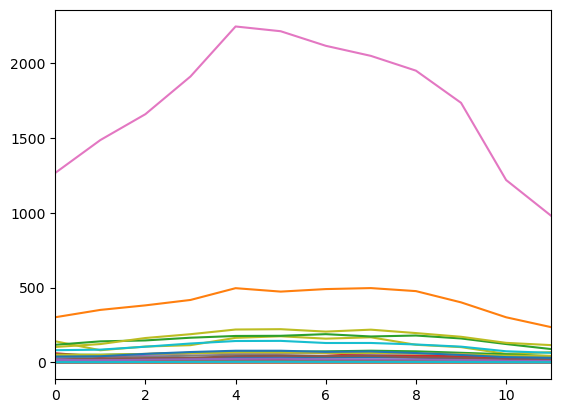

In [30]:
df_solar_energy.drop("series_key", axis=1).plot(legend=False) ## 2015 data over the year

In [33]:
## Getting state air quality data
df_state_air_quality = df[~df["state_abbr"].isin(["AK", "DC"])][["state_abbr", "aqi_max", "aqi_90th_percentile",
                                                                 "aqi_median", "area_km2"]].groupby("state_abbr").agg({
     
    "aqi_max": weighted_mean("area_km2"),
    "aqi_median": weighted_mean("area_km2"),
    "aqi_90th_percentile": weighted_mean("area_km2"),
    "area_km2": np.nansum
    
}).reset_index()

df_state_air_quality.head()

,state_abbr,aqi_max,aqi_median,aqi_90th_percentile,area_km2
0,AL,118.086050,39.662912,55.261023,133736.343580
1,AR,91.040024,32.730353,51.299529,137731.734857
2,AZ,183.772251,42.319803,63.973267,295233.083253
3,CA,320.986785,55.446555,103.042756,409370.521468
4,CO,94.360330,35.351440,51.331180,269602.883701


In [34]:
# Keeping only the state names in the solar data
df_solar_energy.columns = [a.split("_")[-2] for a in df_solar_energy.columns]

In [35]:
# Creating a dictionary with the relevant data
solar_energy_gwh_dict = df_solar_energy.T.iloc[1:,:].sum(axis=1).to_dict()

In [36]:
## Getting the data for total electricity consumed by each state
## Dividing total solar energy by that to get fraction of solar in the state
energy_df = pd.read_excel("annual_generation_state.xls", skiprows=1)
energy_df = energy_df[(energy_df["YEAR"]==2015) & (energy_df["TYPE OF PRODUCER"]=="Total Electric Power Industry")
                     & (energy_df["ENERGY SOURCE"]=="Total") & (energy_df["STATE"].str.len() == 2)]

energy_mwh_dict = energy_df[["STATE", "GENERATION (Megawatthours)"]].set_index("STATE").to_dict()["GENERATION (Megawatthours)"]

energy_df = pd.DataFrame([solar_energy_gwh_dict, energy_mwh_dict]).T
energy_df.columns = ["solar_energy_2015_gwh", "energy_2015_mwh"]

energy_df["solar_fraction"] = energy_df.apply(lambda x: x["solar_energy_2015_gwh"] * 1000 / x["energy_2015_mwh"], axis=1)
energy_df = energy_df.fillna(0).sort_values("solar_fraction")

energy_df_dict = energy_df.to_dict()["solar_fraction"]

# energy_df_dict = defaultdict(int, energy_df_dict)

In [37]:
pd.reset_option("all") ## Reset option to be able to see geodataframe polygons with abstraction

# calculating centroid for plotting
gdf = gpd.read_file(os.path.join("tl_2017_us_state", "tl_2017_us_state.shp"))
gdf["centroid"] = gdf["geometry"].apply(lambda x: x.centroid)

## Keeping states only having solar fraction values # removing territories of the US
gdf = gdf[gdf["STUSPS"].isin(energy_df_dict.keys())]

## Creating solar fraction column
gdf["solar_fraction"] = gdf["STUSPS"].apply(lambda x: energy_df_dict[x])

## Merging with the air quality dataframe
gdf = gdf.merge(df_state_air_quality, how="right", left_on="STUSPS", right_on="state_abbr")
gdf = gdf.set_geometry("centroid")
gdf = gdf[~gdf["STUSPS"].isin(["RI", "HI"])]
gdf = gdf.sort_values("solar_fraction", ascending=False)


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



C:\Users\KL-LocalAdmin\Anaconda3\lib\site-packages\pandas\_config\config.py:622: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


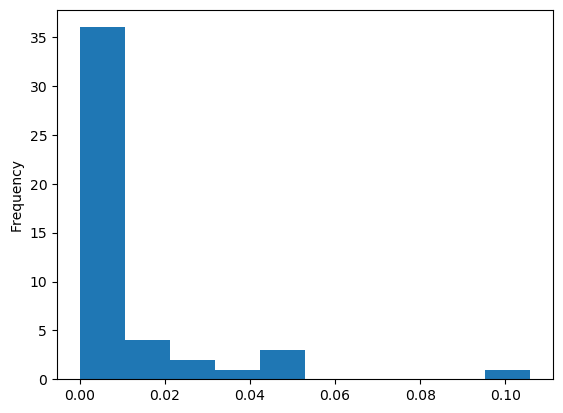

In [38]:
## Exploratory visualizations
gdf['solar_fraction'].plot.hist()

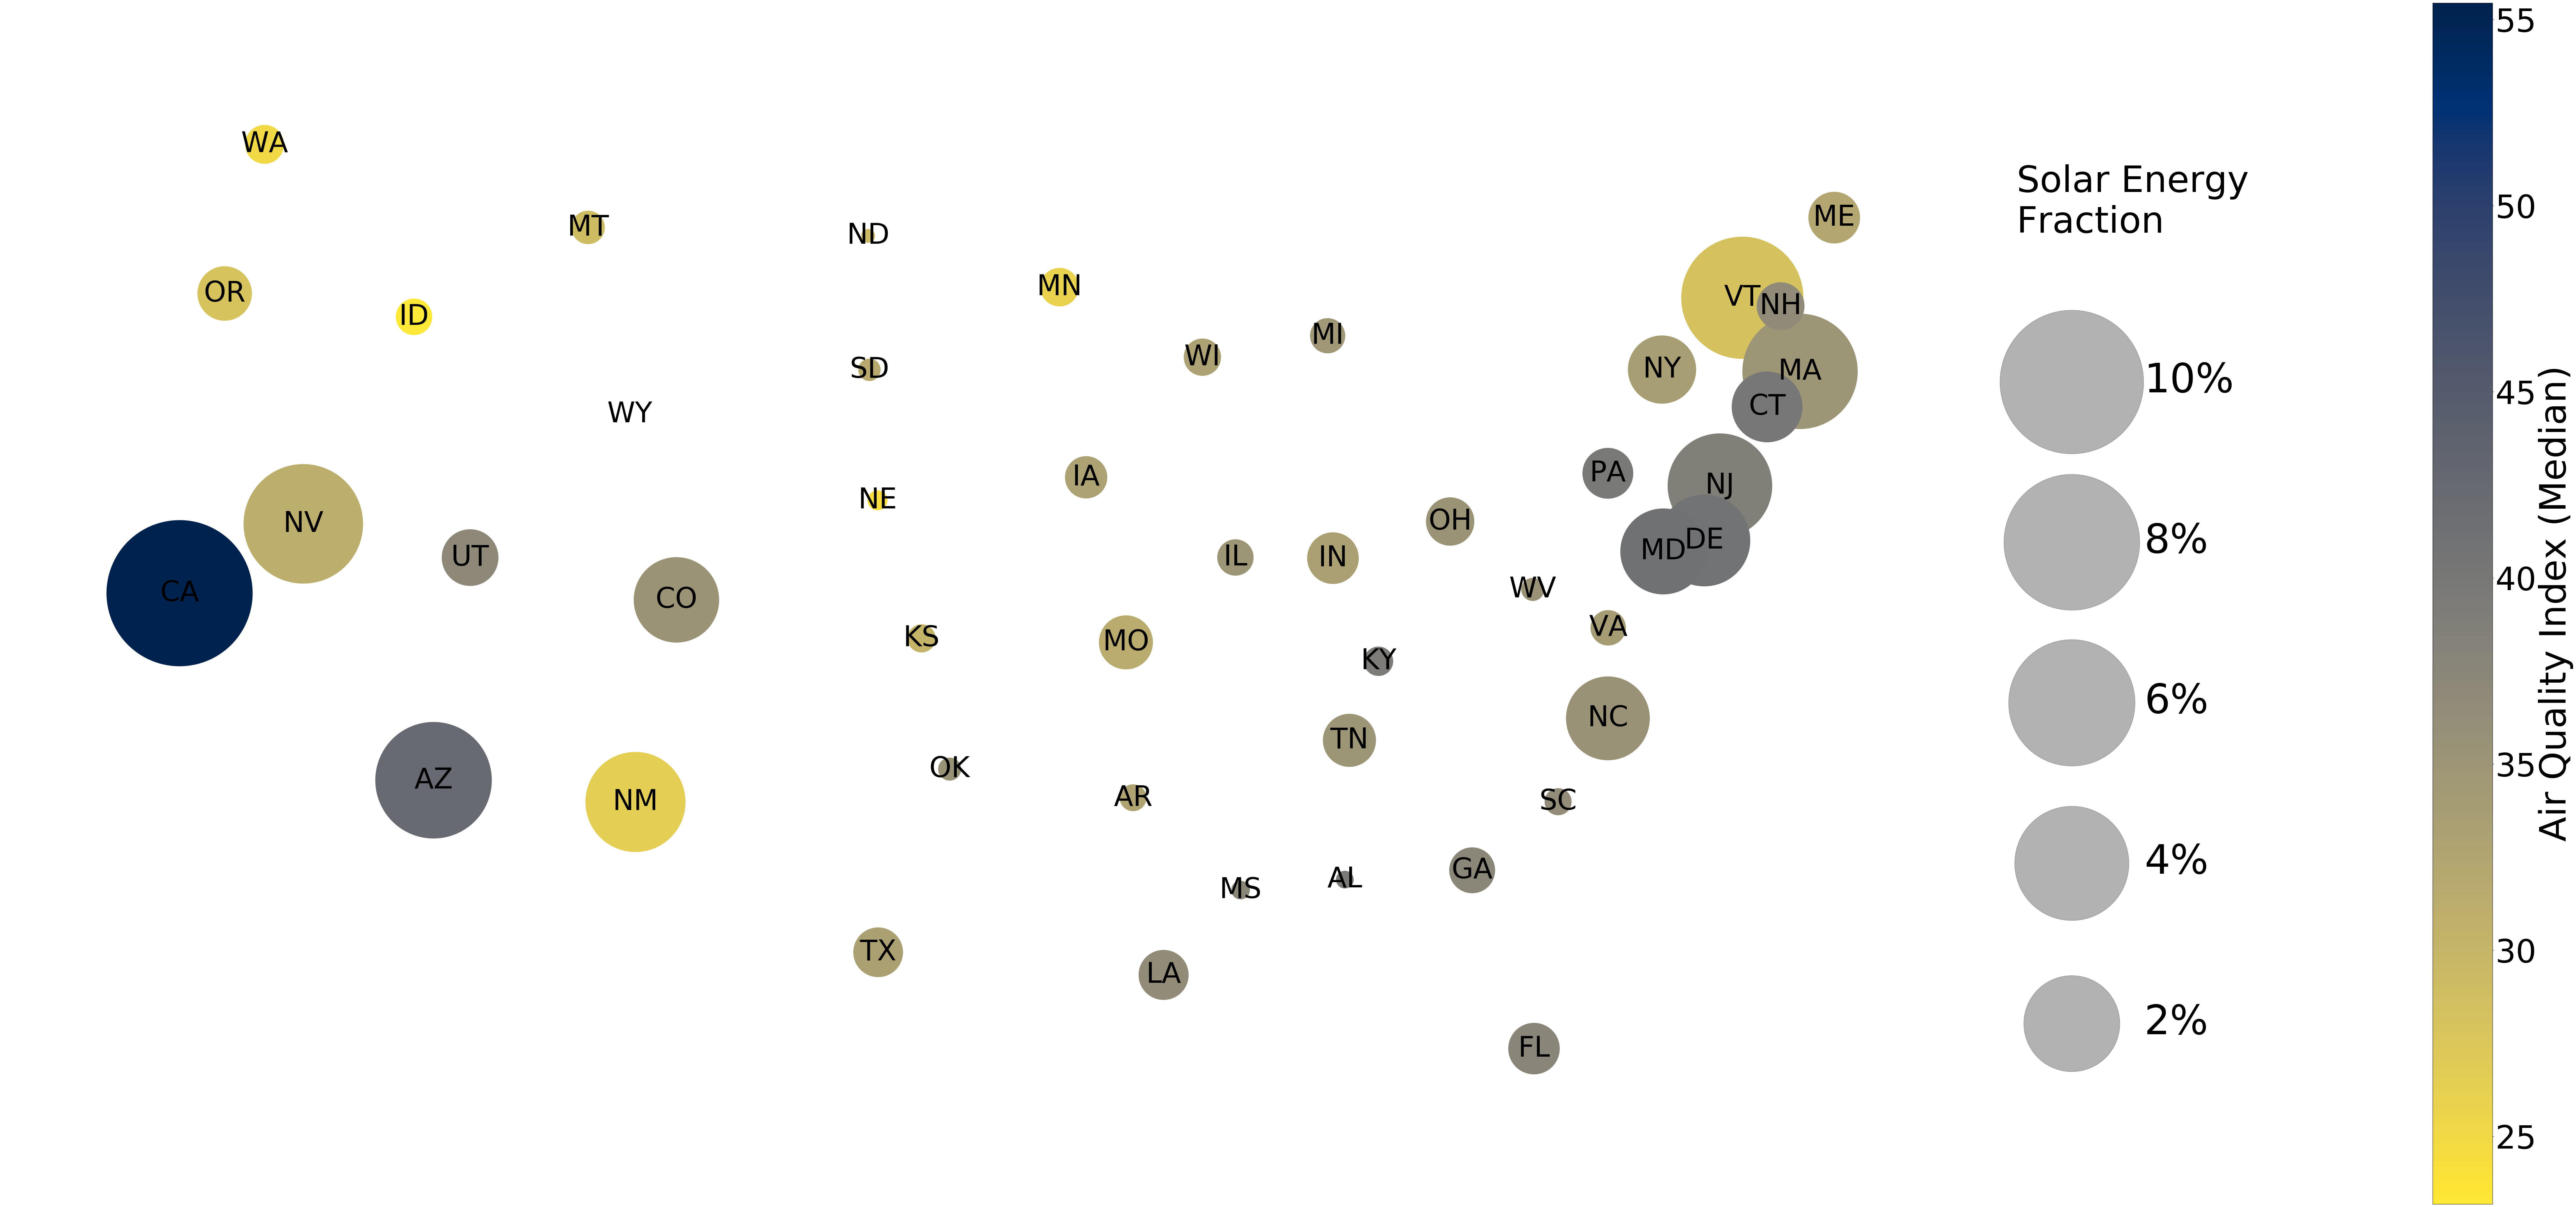

In [42]:

## Setting default size
matplotlib.rcdefaults()
font = {'size': 90}
matplotlib.rc('font', **font)


## Scaling functions for circle size
def scale_function(x):
    return (np.sqrt(x)) * 10 ** 5 * 4

## Changing tick sizes
matplotlib.rc('xtick', labelsize=80) 
matplotlib.rc('ytick', labelsize=80) 

## Large size plots
fig, ax = plt.subplots(figsize=(104, 44))
## Proj string for albers equal conic area projection esri:102003
proj_string = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs "

## Using colorblin-friendly colormap
bubble_map = gdf.to_crs(proj_string).plot(column="aqi_median", markersize=scale_function(gdf["solar_fraction"]),
                                          cmap="cividis_r", ax=ax, legend=False)

# Need to create colorbar separately
norm = colors.Normalize(vmin=gdf.aqi_median.min(), vmax=gdf.aqi_median.max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='cividis_r')
ax_cbar = fig.colorbar(cbar, ax=ax, label="Air Quality Index (Median)")

## Annotate every state on top of the dot
for idx, row in gdf.to_crs(proj_string).iterrows():
    ax.annotate(s=row["STUSPS"], xy=[row["centroid"].x, row["centroid"].y], fontsize=70, ha="center", va="center")


## Create secondary legend
solar_size_list = ["10%", "8%", "6%", "4%", "2%"]
for i, area in enumerate([0.1, 0.08, 0.06, 0.04, 0.02]):
    plt.scatter([], [], c='k', alpha=0.3, s=scale_function(area), label=solar_size_list[i])
    
legend = plt.legend(scatterpoints=1, framealpha=0, labelspacing=3, loc="center right", title="Solar Energy\nFraction", prop={'size': 100})
    

## Create limits for x axis and y axis and remove ticks
ax.set_xlim(-2.5 * 10e5, 3.2 * 10e5)
ax.set_ylim(-1.3 * 10e5, 1.7 * 10e5)
ax.set_xticks([])
ax.set_yticks([])

## Remove frame to make image clean
fig.patch.set_visible(False)
ax.axis('off')

plt.tight_layout()
plt.show()